# Rodando os modelos com Cross Validation

In [33]:
# Bibliotecas de manipualção e visualização de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler

# Classes dos modelo
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Funções de avaliação dos modelos
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ROCAUC


In [34]:
df_hepatite = pd.read_csv('HCV-Egy-Data.csv')

In [35]:
# dataset sem outliers
df_hepatite = pd.read_csv('HCV-Egy-Data-no-outlier.csv')

A remoção de outliers mostrou-se eficiente na performace do modelo aumentando em serca de 1% a acurácia.

In [36]:
df_hepatite.head()

Unnamed: 0  Age  Gender  BMI  Fever  Nausea/Vomting  Headache  Diarrhea  \
0           1   46       1   29      1               2         2         1   
1           3   49       2   33      1               2         1         2   
2           5   58       2   22      2               2         2         1   
3           6   42       2   26      1               1         2         2   
4           7   48       2   30      1               1         2         2   

   FGba  Jaundice  ...  ALT 36  ALT 48  ALT after 24 w  RNA Base    RNA 4  \
0     2         2  ...      57     123              44     40620   538635   
1     1         2  ...      48      77              33   1041941   449939   
2     2         2  ...      73     114              29   1157452  1086852   
3     2         2  ...      84      80              28    325694  1034008   
4     1         1  ...      96      53              39    641129    72050   

   RNA 12  RNA EOT  RNA EF  BhG  Baselinehistological staging  
0  637056   336804   31085    4                             2  
1  585688   744463  582301   10                             3  
2       5        5       5    4                             4  
3  275095   214566  635157   12                             4  
4  787295   370605  506296   12                             3  

[5 rows x 30 columns]

### Seperação da váriável target do dataset

In [37]:
X = df_hepatite.drop(['BhG', 'Baselinehistological staging'], axis=1)
y = df_hepatite['Baselinehistological staging']

### Normalização dos dados

Com a normalização dos dados o modelo melhorou de predição almentou em um valor de 6% na sua acurácia.

In [38]:
scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X)

In [39]:
#função que retorna um dicionário com os valores dos resultados
def model_results(model, X_train, y_train, X_test, y_test,results_dict_aux):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #medindo e armazenando acurácia, f1-score e auc-score no dicionário
    accuracy = model.score(X_test, y_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    AUC = roc_auc_score(y_test, model.predict_proba(X_test), average='weighted', multi_class='ovo')
    CM = confusion_matrix(y_test, y_pred)

    results_dict_aux['accuracy'].append(accuracy)
    results_dict_aux['f1'].append(f1)
    results_dict_aux['auc'].append(AUC)
    results_dict_aux['cm'].append(CM)
    print(f"f1: {f1}\n")
    print(f"AUC: {AUC}\n")
    print(f"Accuracy: {accuracy}\n")
    print(f"CM: \n{CM} \n")
    
    print("-------CURVA ROC-----------\n")
    visualizer = ROCAUC(model, encoder={1:"Class 1", 2:"Class 2", 3:"Class 3", 4:"Class 4"})

    visualizer.fit(X_train, y_train)        
    visualizer.score(X_test, y_test)        
    visualizer.show()                       
    print("------------------\n")
    return results_dict_aux

## Grid Search

Para cada modelo é implementada uma função do grid search. Para ser aplicada em cada um dos 10 conjuntos de treino do 10-fold.

**KNN**

In [40]:
def kNN_grid_search(X_train, y_train):
    #lista com números impares para o número de vizinhos do knn
    k_range = [impar for impar in range(1,32) if (impar%2)!=0]
    #listas com formas de considerar a ditância do vizinho
    weights = ['uniform', 'distance']
    #lista com formas de calcular as distâncias
    dist = ['euclidian','manhattan','chebyshev']
    #dicionário com parêmetros para o gridsearch
    param_grid = {
        'n_neighbors': k_range,
        'weights': weights,
        'metric': dist
    }
    # defining parameter range
    grid = GridSearchCV(knn(), param_grid, cv=3, scoring='accuracy')
    # fitting the model for grid search
    grid.fit(X_train, y_train)

    #utilizando melhores parâmetros calculados pelo gridsearch
    k = grid.best_params_['n_neighbors']
    w = grid.best_params_['weights']
    m = grid.best_params_['metric']

    print("KNN \n")
    print(f"k:{k}, w:{w}, m:{m}\n")
    print(grid.best_score_*100)
    print("\n---------------------------")

    return (k,w,m)

**Decision Tree**

In [41]:
def dt_grid_search(X_train, y_train):
    #
    max_depth_range = [x for x in range(1,32)]
    #listas com formas de medir a qualidade do 'split'
    criterion_list = ['gini', 'entropy']
    #dicionário com parêmetros para o gridsearch
    param_grid = {
        'max_depth': max_depth_range,
        'criterion': criterion_list,
    }
    # defining parameter range
    grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=3, scoring='accuracy')
    # fitting the model for grid search
    grid.fit(X_train, y_train)

    #utilizando melhores parâmetros calculados pelo gridsearch
    md = grid.best_params_['max_depth']
    c = grid.best_params_['criterion']

    print("DT \n")
    print(f"md:{md}, c:{c}\n")
    print(grid.best_score_*100)  
    print("\n---------------------------")


    return (md,c)

**MLP**

In [42]:
def mlp_grid_search(X_train, y_train):
    # lista com o número de camadas
    hidden_layer_sizes_list = [(100,), (50, 15, 5), (100, 25, 10)]
    # listas das taxas de aprendizado inicial
    learning_rate_init_list = [0.05, 0.0001]
    # lista de estratégias
    solver_list = ['sgd', 'adam']
    # lista das funções de ativações
    activation_list = ['tanh', 'relu']
    # lista da forma da taxa de aprendizado
    learning_rate_lsit = ['constant', 'adaptive']
    # dicionário com parêmetros para o gridsearch
    param_grid = {
        'hidden_layer_sizes': hidden_layer_sizes_list,
        'activation': activation_list,
        'solver': solver_list,
        'learning_rate': learning_rate_lsit,
        'learning_rate_init': learning_rate_init_list,
    }
    # defining parameter range
    grid = GridSearchCV(MLPClassifier(), param_grid, cv=3, scoring='accuracy')
    # fitting the model for grid search
    grid.fit(X_train, y_train)

    # utilizando melhores parâmetros calculados pelo gridsearch
    hls = grid.best_params_['hidden_layer_sizes']
    a = grid.best_params_['activation']
    s = grid.best_params_['solver']
    lr = grid.best_params_['learning_rate']
    lri = grid.best_params_['learning_rate_init']

    print("MLP \n")
    print(f"hls:{hls}, a:{a}, s:{s}, lr:{lr}, lri:{lri}\n")
    print(grid.best_score_*100)
    print("\n---------------------------")

    return (hls, a, s, lr, lri)

**SVM**

In [43]:
def svm_grid_search(X_train, y_train):
    #
    C_list = [0.1, 1, 10, 100]
    kernel_list = ['rbf','sigmoid'] #['linear', 'poly', 'rbf', 'sigmoid']
    gamma_list = [1, 0.1, 0.01, 0.001]
    #dicionário com parêmetros para o gridsearch
    param_grid = {
        'C': C_list,
        'kernel': kernel_list,
        'gamma': gamma_list
    }
    # defining parameter range
    grid = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy')
    # fitting the model for grid search
    grid.fit(X_train, y_train)

    #utilizando melhores parâmetros calculados pelo gridsearch
    c = grid.best_params_['C']
    k = grid.best_params_['kernel']
    g = grid.best_params_['gamma']

    print("SVM \n")
    print(f"C:{c}, k:{k}\n, g:{g}\n")
    print(grid.best_score_*100)
    print("\n---------------------------")

    return (c,k,g)

## 10-Fold

Com esse método são criados 10 datasets de treino e 10 datasets de test com uma divisão de 90% para treino e 10% para teste em cada divisão.

O conjunto de treino sera divido mais uma vez em treino e validação (isso é feito dendo da função `GridSearchCV` para que então seja aplicado o GridSearch e assim obtenha-se os melhores parâmetros. Por fim, tendo os melhores parâmetros, utiliza-se o conjunto de teste para que se possa avaliar os resultados.

Esses resultados são obtidos de cada fold e então se tira a média deles para obter-se a avaliação final de cada modelo.

In [44]:
#função que roda os modelos em cada uma das divisões do 10-fold
#e imprime a média e o desvio padrão dos resultados

def evaluate_model_with_kfold(kf):
    results_dict_models = {}
    # listas e dicionarios para salvar as métricas dos resultados de todas as interacoes
    
    results_dict_KNN = {
        'accuracy': [],
        'f1': [],
        'auc': [],
        'cm': []
    }
    results_dict_DT = {
        'accuracy': [],
        'f1': [],
        'auc': [],
        'cm': []
    }
    results_dict_MLP = {
        'accuracy': [],
        'f1': [],
        'auc': [],
        'cm': []
    }
    results_dict_SVM = {
        'accuracy': [],
        'f1': [],
        'auc': [],
        'cm': []
    }
    results_dict_GNB = {
        'accuracy': [],
        'f1': [],
        'auc': [],
        'cm': []
    }

    
    count = 1
    
    for train, test in kf.split(X, y):
        X_train, y_train, X_test, y_test = X.iloc[train], y.iloc[train], X.iloc[test], y.iloc[test]        

        #kNN
        k,w,m = kNN_grid_search(X_train, y_train)
        model = knn(n_neighbors=k, weights=w, metric=m)
        results_dict_KNN = model_results(model, X_train, y_train, X_test, y_test, results_dict_KNN)
        if (count == 10):
            results_dict_models['KNN'] = results_dict_KNN
  
        #DT
        md,c = dt_grid_search(X_train, y_train)
        model = DecisionTreeClassifier(max_depth=md, criterion=c, random_state=199)
        results_dict_DT = model_results(model, X_train, y_train, X_test, y_test, results_dict_DT)
        if (count == 10):
            results_dict_models['DT'] = results_dict_DT

        #MLP 
        hls, a, s, lr, lri = mlp_grid_search(X_train,y_train)
        model = MLPClassifier(
            hidden_layer_sizes=hls, 
            activation=a, 
            solver=s, 
            learning_rate=lr, 
            learning_rate_init=lri, 
            max_iter=2000, 
            tol=0.000001,
            random_state=199
        )
        results_dict_MLP = model_results(model, X_train, y_train, X_test, y_test, results_dict_MLP)
        if (count == 10):
            results_dict_models['MLP'] = results_dict_MLP
         
        #GNB 
        model = GaussianNB()
        results_dict_models['GNB'] = model_results(model, X_train, y_train, X_test, y_test, results_dict_GNB)

        
        #SVM
        c, k, g = svm_grid_search(X_train, y_train)
        model = SVC(C=c, kernel=k, gamma=g, probability=True, random_state=199)
        results_dict_SVM = model_results(model, X_train, y_train, X_test, y_test, results_dict_SVM)
        if (count == 10):
            results_dict_models['SVM'] = results_dict_SVM

        count = count + 1

    # a cada interação calcula a média e o desvio padrão da 
    # acurácia, f1-score, auc-scor e matriz de confusão de cada modelo
    for model_key in results_dict_models.keys():
        accuracies = np.array(results_dict_models[model_key]['accuracy'])
        f1 = np.array(results_dict_models[model_key]['f1'])
        auc = np.array(results_dict_models[model_key]['auc'])
        conf_matrix = np.array(results_dict_models[model_key]['cm'])

        print(model_key)
        print("Acurácia média (desvio): %.6f +- (%.9f)" %(accuracies.mean(), accuracies.std()))
        print("F1-score média (desvio): %.6f +- (%.9f)" %(f1.mean(), f1.std()))
        print("AUC média (desvio): %.6f +- (%.9f)\n" %(auc.mean(), auc.std()))
        print(f"Matriz de Confusão:  \n{sum(conf_matrix)}\n")
        # print(f"Matriz de Confusão:  \n{sum(conf_matrix)*0.1}\n")
        print("\n---------------------------")

C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'euclidian' not valid. Use sorted(sklearn.ne

C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'euclidian' not valid. Use sorted(sklearn.ne

KNN 

k:19, w:uniform, m:chebyshev

27.777777777777775

---------------------------
f1: 0.24776950229709707

AUC: 0.5031896051786022

Accuracy: 0.2446043165467626

CM: 
[[ 7  7 10 10]
 [11  9  8  6]
 [12  5 10  8]
 [12  4 12  8]] 

-------CURVA ROC-----------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.25040258 0.25040258 0.23913043 0.25120773
 0.25523349 0.24476651 0.24476651 0.25362319 0.24074074 0.24235105
 0.24879227 0.2431562  0.25120773 0.25040258 0.25845411 0.2431562
 0.25201288 0.24798712 0.25603865 0.25040258 0.25362319 0.2568438
 0.24959742 0.25362319 0.24557166 0.24557166 0.26086957 0.26086957
 0.2568438  0.26247987 0.2568438  0.25925926 0.25523349 0.25523349
 0.25603865 0.25523349 0.26086957 0.26086957 0.25201288 0.25442834
 0.25201288 0.24396135 0.24718196 0.239

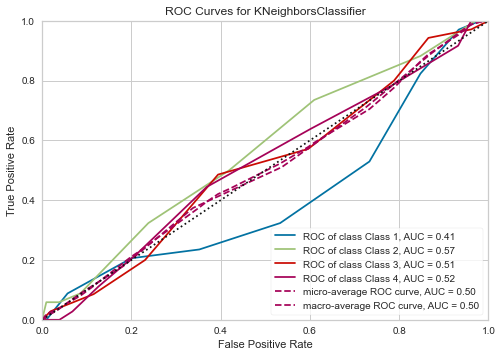

------------------

DT 

md:24, c:entropy

26.73107890499195

---------------------------
f1: 0.2789113963592086

AUC: 0.5199640847546053

Accuracy: 0.2805755395683453

CM: 
[[ 7 13  5  9]
 [ 5 10 12  7]
 [ 5  7 11 12]
 [10  4 11 11]] 

-------CURVA ROC-----------



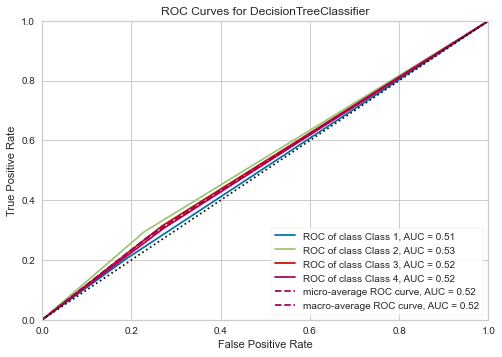

------------------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users

MLP 

hls:(100,), a:relu, s:adam, lr:adaptive, lri:0.0001

27.214170692431566

---------------------------
f1: 0.22772051759730352

AUC: 0.4834846968363684

Accuracy: 0.2302158273381295

CM: 
[[ 8  8  6 12]
 [ 9  5  9 11]
 [10  6  9 10]
 [ 5  7 14 10]] 

-------CURVA ROC-----------



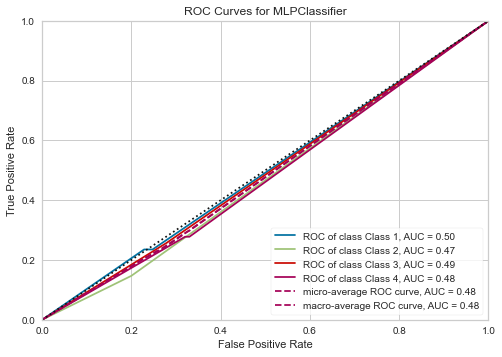

------------------

f1: 0.1685577898277304

AUC: 0.46126622511514603

Accuracy: 0.17985611510791366

CM: 
[[ 2  8  8 16]
 [ 5  7 10 12]
 [ 6  9  4 16]
 [ 8  7  9 12]] 

-------CURVA ROC-----------



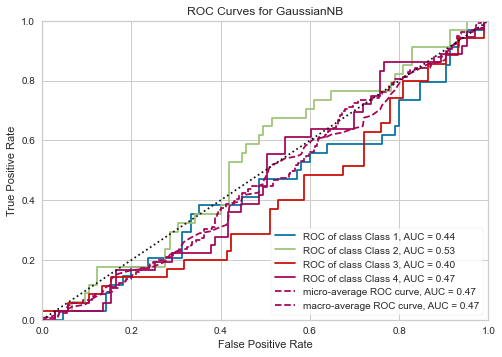

------------------

SVM 

C:0.1, k:rbf
, g:1

26.08695652173913

---------------------------
f1: 0.10655704008221994

AUC: 0.5

Accuracy: 0.2589928057553957

CM: 
[[ 0  0  0 34]
 [ 0  0  0 34]
 [ 0  0  0 35]
 [ 0  0  0 36]] 

-------CURVA ROC-----------



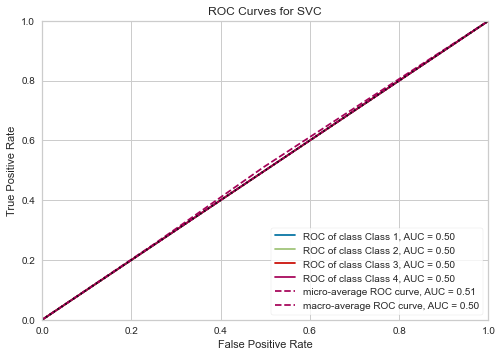

------------------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'euclidian' not valid. Use sorted(sklearn.ne

C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'euclidian' not valid. Use sorted(sklearn.ne

KNN 

k:5, w:uniform, m:chebyshev

26.94992530508507

---------------------------
f1: 0.3091570921202301

AUC: 0.5356951154052604

Accuracy: 0.3115942028985507

CM: 
[[13  8  8  4]
 [10 12  4  7]
 [ 8 11  9  8]
 [ 5 13  9  9]] 

-------CURVA ROC-----------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.2461925  0.2461925  0.25822905 0.257453
 0.25984906 0.2526085  0.25583493 0.25341753 0.25905361 0.25985488
 0.25502784 0.25422657 0.24537183 0.24698601 0.24779699 0.24699183
 0.25664203 0.2534253  0.25181499 0.25825039 0.2502008  0.25664009
 0.24616922 0.25182081 0.24858662 0.25181499 0.25179753 0.24456473
 0.24295055 0.24618086 0.25662457 0.24537183 0.25262402 0.25262402
 0.25824069 0.25583493 0.26949925 0.26145936 0.25584075 0.26548513
 0.24297771 0.24860796 0.2485905  0.257

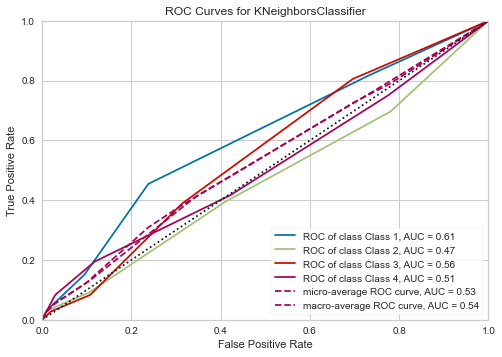

------------------

DT 

md:15, c:gini

26.951671419979434

---------------------------
f1: 0.1869757854789929

AUC: 0.45550462352998583

Accuracy: 0.18840579710144928

CM: 
[[ 9  9 10  5]
 [ 9  3 11 10]
 [ 7 10  5 14]
 [ 8  6 13  9]] 

-------CURVA ROC-----------



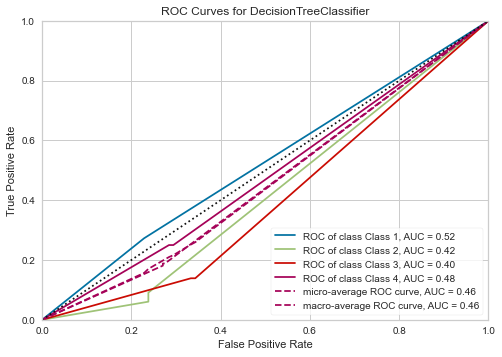

------------------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users

MLP 

hls:(100,), a:relu, s:adam, lr:constant, lri:0.0001

26.86882796888035

---------------------------
f1: 0.16900696793121717

AUC: 0.501990008783487

Accuracy: 0.2536231884057971

CM: 
[[16  0  0 17]
 [13  0  0 20]
 [18  0  0 18]
 [17  0  0 19]] 

-------CURVA ROC-----------



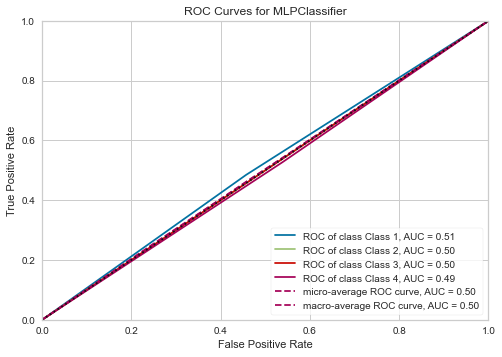

------------------

f1: 0.22796238934490035

AUC: 0.4584278778119357

Accuracy: 0.2318840579710145

CM: 
[[ 7  5  8 13]
 [ 3  5 12 13]
 [ 5 12  6 13]
 [ 4 10  8 14]] 

-------CURVA ROC-----------



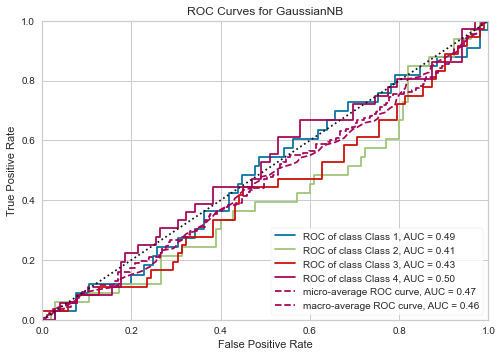

------------------

SVM 

C:0.1, k:rbf
, g:1

26.066003143006807

---------------------------
f1: 0.10794602698650674

AUC: 0.5

Accuracy: 0.2608695652173913

CM: 
[[ 0  0  0 33]
 [ 0  0  0 33]
 [ 0  0  0 36]
 [ 0  0  0 36]] 

-------CURVA ROC-----------



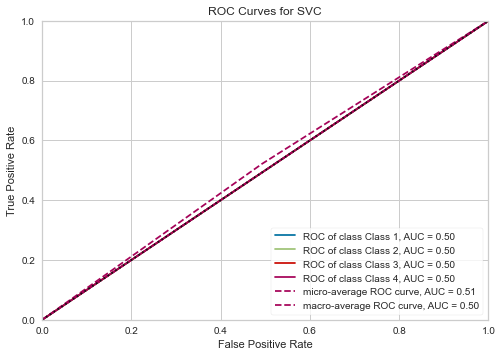

------------------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'euclidian' not valid. Use sorted(sklearn.ne

KNN 

k:15, w:uniform, m:manhattan

25.584463457695517

---------------------------
f1: 0.3474137579097775

AUC: 0.5579374664519593

Accuracy: 0.34782608695652173

CM: 
[[14  5  7  7]
 [ 4 10  9 10]
 [13  7 11  5]
 [ 6  5 12 13]] 

-------CURVA ROC-----------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.24778922 0.24778922 0.23652678 0.25019886
 0.23973381 0.24858856 0.23974546 0.24296219 0.24216673 0.23813127
 0.2477931  0.24618668 0.24859632 0.2437751  0.25584463 0.24538347
 0.24535242 0.23894224 0.24537765 0.24858856 0.25181111 0.24939953
 0.24215315 0.24457443 0.24457249 0.23814485 0.24939565 0.24779116
 0.24456667 0.24055061 0.24778146 0.24054479 0.24538153 0.24538153
 0.23410744 0.24779699 0.24777952 0.24778728 0.23412103 0.24376928
 0.23893254 0.24699377 0.2502008  0.2

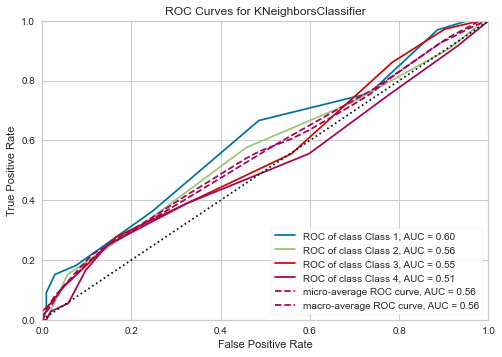

------------------

DT 

md:17, c:gini

26.549288943212463

---------------------------
f1: 0.21692258592069555

AUC: 0.47560599960962285

Accuracy: 0.21739130434782608

CM: 
[[ 7  8 12  6]
 [ 7  7 11  8]
 [ 8  7  9 12]
 [10 10  9  7]] 

-------CURVA ROC-----------



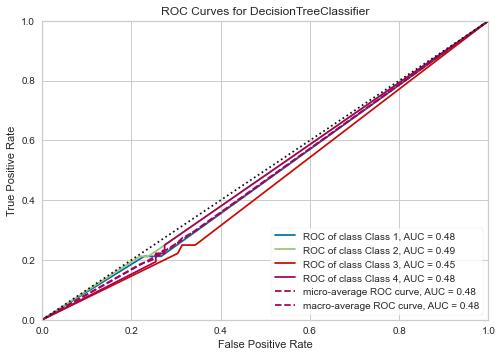

------------------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users

MLP 

hls:(100,), a:tanh, s:sgd, lr:constant, lri:0.0001

28.56275342917564

---------------------------
f1: 0.2018726405980552

AUC: 0.4505776362660421

Accuracy: 0.21739130434782608

CM: 
[[ 3  4  9 17]
 [ 7  4  9 13]
 [ 5  6  8 17]
 [ 5 10  6 15]] 

-------CURVA ROC-----------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


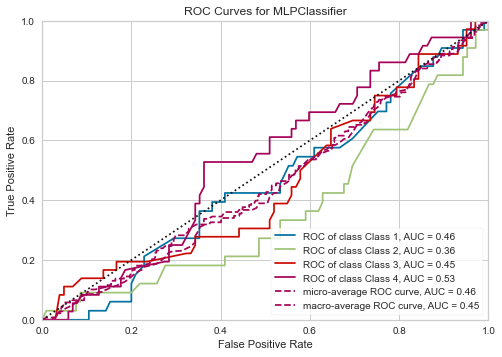

------------------

f1: 0.20207761927173779

AUC: 0.47425340360122964

Accuracy: 0.21739130434782608

CM: 
[[ 1 10 15  7]
 [ 5  9  7 12]
 [ 3 11  8 14]
 [ 5 13  6 12]] 

-------CURVA ROC-----------



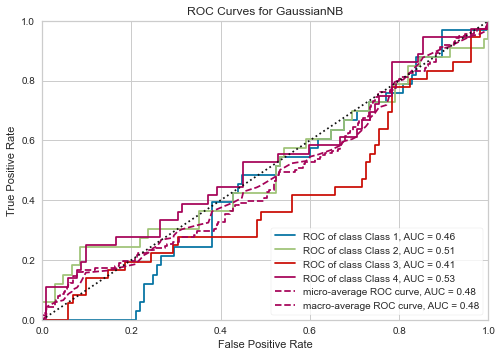

------------------

SVM 

C:0.1, k:rbf
, g:1

26.066003143006807

---------------------------
f1: 0.10794602698650674

AUC: 0.5

Accuracy: 0.2608695652173913

CM: 
[[ 0  0  0 33]
 [ 0  0  0 33]
 [ 0  0  0 36]
 [ 0  0  0 36]] 

-------CURVA ROC-----------



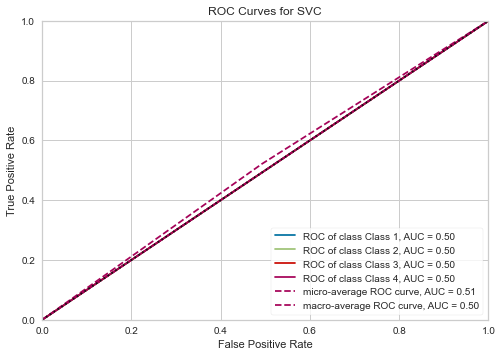

------------------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'euclidian' not valid. Use sorted(sklearn.ne

C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'euclidian' not valid. Use sorted(sklearn.ne

KNN 

k:19, w:uniform, m:chebyshev

27.9985643055313

---------------------------
f1: 0.2554147628244383

AUC: 0.5021638486312399

Accuracy: 0.2536231884057971

CM: 
[[ 6 10 10  7]
 [14  6  5  8]
 [ 6  9 12  9]
 [11  7  7 11]] 

-------CURVA ROC-----------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.24135382 0.24135382 0.24133442 0.24053703
 0.2614419  0.25502202 0.24615952 0.24616922 0.26146712 0.26146906
 0.24537377 0.24537183 0.25100596 0.25340783 0.2574336  0.24937625
 0.25822711 0.25179559 0.26066197 0.25179365 0.25099044 0.25099044
 0.25743942 0.25582717 0.24698795 0.24939565 0.25581359 0.25099432
 0.25743748 0.24456085 0.25503172 0.23974157 0.25099238 0.25099238
 0.27110374 0.26467222 0.24698407 0.25904196 0.25343888 0.24939565
 0.26388452 0.25181111 0.27031993 0.2

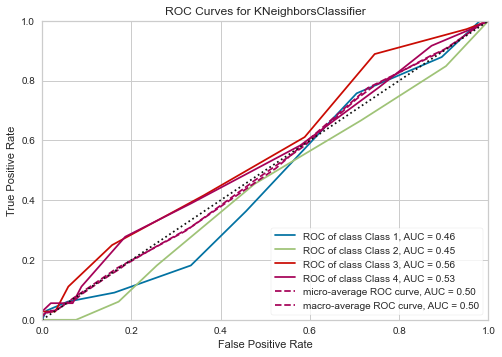

------------------

DT 

md:20, c:gini

25.502008032128515

---------------------------
f1: 0.252170141809609

AUC: 0.5028912311521008

Accuracy: 0.2536231884057971

CM: 
[[ 6  8 12  7]
 [ 6 13 10  4]
 [13  7  8  8]
 [ 6 10 12  8]] 

-------CURVA ROC-----------



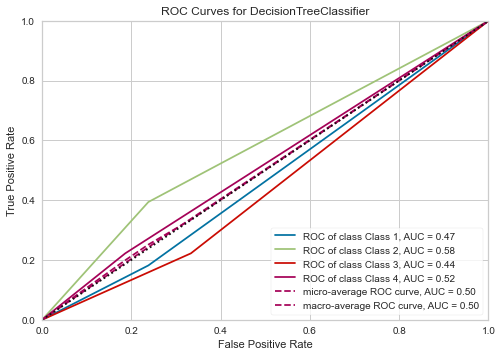

------------------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users

MLP 

hls:(100, 25, 10), a:tanh, s:adam, lr:constant, lri:0.0001

26.629610228353023

---------------------------
f1: 0.25306822249715816

AUC: 0.5246654345386229

Accuracy: 0.2608695652173913

CM: 
[[ 6  1 15 11]
 [ 6  5  9 13]
 [ 7  2 14 13]
 [ 8  5 12 11]] 

-------CURVA ROC-----------



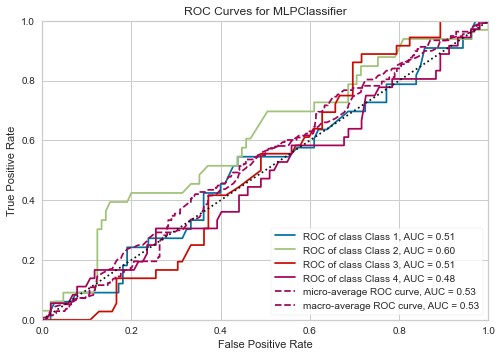

------------------

f1: 0.23318908419650727

AUC: 0.4807068267213195

Accuracy: 0.2463768115942029

CM: 
[[ 1  8 11 13]
 [ 3  9 11 10]
 [14  7  8  7]
 [ 3  6 11 16]] 

-------CURVA ROC-----------



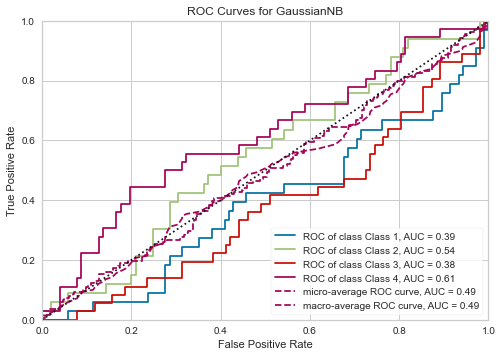

------------------

SVM 

C:0.1, k:rbf
, g:1

26.066003143006807

---------------------------
f1: 0.10794602698650674

AUC: 0.5

Accuracy: 0.2608695652173913

CM: 
[[ 0  0  0 33]
 [ 0  0  0 33]
 [ 0  0  0 36]
 [ 0  0  0 36]] 

-------CURVA ROC-----------



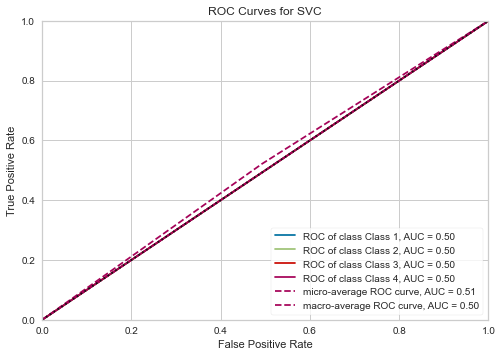

------------------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'euclidian' not valid. Use sorted(sklearn.ne

KNN 

k:19, w:uniform, m:chebyshev

28.07869157790583

---------------------------
f1: 0.20470378845664886

AUC: 0.45589500073195727

Accuracy: 0.21014492753623187

CM: 
[[ 8  6  6 13]
 [10  2 13  8]
 [10  9  9  8]
 [11  7  8 10]] 

-------CURVA ROC-----------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.25262208 0.25262208 0.24535436 0.25663039
 0.26307161 0.26227034 0.27354636 0.26468968 0.25582911 0.2526279
 0.25180529 0.25341753 0.26465863 0.25582523 0.26387094 0.25824457
 0.25904585 0.26227422 0.27031993 0.26951283 0.2646858  0.27112702
 0.26467998 0.26146906 0.25342918 0.24860408 0.26549289 0.25986264
 0.26226452 0.25503366 0.25101178 0.25582523 0.27997788 0.27997788
 0.27432047 0.27997594 0.27192053 0.27032381 0.26710126 0.27354248
 0.25744136 0.26711484 0.27916303 0.27

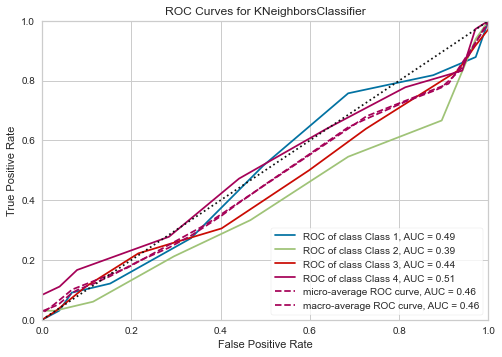

------------------

DT 

md:20, c:gini

26.789282734803948

---------------------------
f1: 0.19943061146427202

AUC: 0.4670985214463475

Accuracy: 0.2028985507246377

CM: 
[[ 3  9 11 10]
 [10  6 10  7]
 [ 5  4 12 15]
 [11 10  8  7]] 

-------CURVA ROC-----------



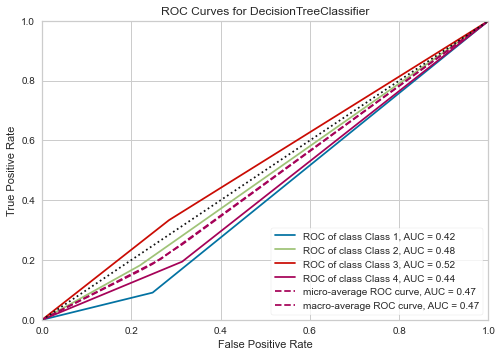

------------------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users

MLP 

hls:(100, 25, 10), a:tanh, s:sgd, lr:constant, lri:0.0001

27.352889820150168

---------------------------
f1: 0.22110798177931787

AUC: 0.4574473600741717

Accuracy: 0.2391304347826087

CM: 
[[ 6  3 11 13]
 [ 5  2 10 16]
 [ 4  4 10 18]
 [ 6  5 10 15]] 

-------CURVA ROC-----------



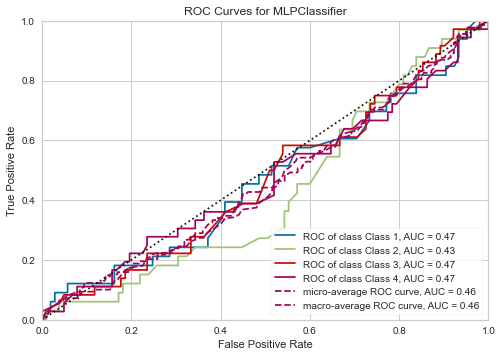

------------------

f1: 0.17193333897619653

AUC: 0.44206863319182155

Accuracy: 0.18840579710144928

CM: 
[[ 3  7 10 13]
 [ 5  8  9 11]
 [ 2 11  1 22]
 [ 1 10 11 14]] 

-------CURVA ROC-----------



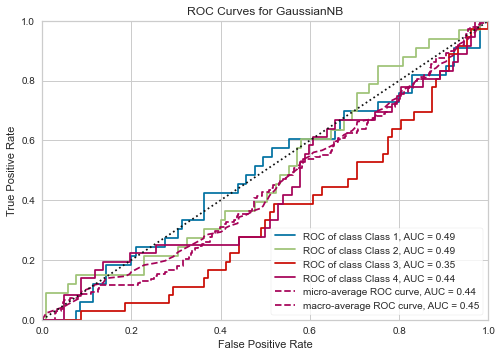

------------------

SVM 

C:0.1, k:rbf
, g:1

26.066003143006807

---------------------------
f1: 0.10794602698650674

AUC: 0.5

Accuracy: 0.2608695652173913

CM: 
[[ 0  0  0 33]
 [ 0  0  0 33]
 [ 0  0  0 36]
 [ 0  0  0 36]] 

-------CURVA ROC-----------



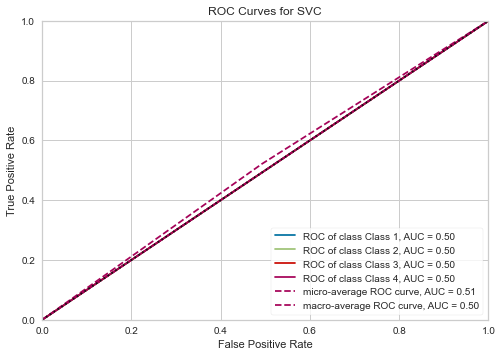

------------------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'euclidian' not valid. Use sorted(sklearn.ne

KNN 

k:3, w:distance, m:chebyshev

27.918243020390744

---------------------------
f1: 0.23286976090873868

AUC: 0.47109531303371893

Accuracy: 0.2391304347826087

CM: 
[[ 7  6 15  5]
 [ 7  5  8 13]
 [ 6  6 14 10]
 [13  6 10  7]] 

-------CURVA ROC-----------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.25262208 0.25262208 0.26386124 0.26467998
 0.27513338 0.26790447 0.26065421 0.25743554 0.26307549 0.25181499
 0.26709932 0.26790253 0.26549289 0.26307161 0.2735289  0.26387676
 0.2646761  0.26468774 0.25985682 0.25343112 0.2711115  0.2711212
 0.26710126 0.26308519 0.27513726 0.26710514 0.26788313 0.25664203
 0.25662651 0.25663427 0.25903808 0.26387094 0.26789865 0.26789865
 0.27352696 0.27918243 0.27675727 0.27434181 0.27354442 0.2622684
 0.27274703 0.26228198 0.26791223 0.267

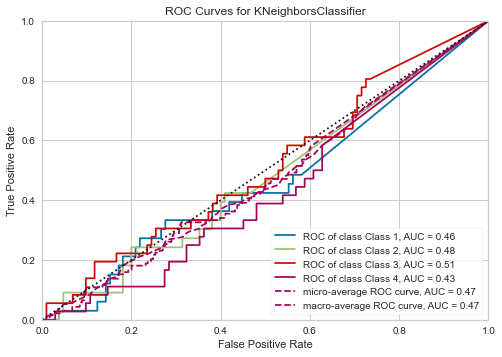

------------------

DT 

md:3, c:gini

26.95108938168131

---------------------------
f1: 0.21022669937540234

AUC: 0.500744156541258

Accuracy: 0.2826086956521739

CM: 
[[ 5  1  0 27]
 [ 8  4  2 19]
 [ 3  7  1 25]
 [ 2  4  1 29]] 

-------CURVA ROC-----------



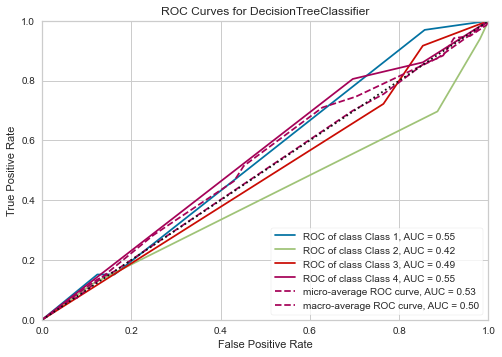

------------------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users

MLP 

hls:(100, 25, 10), a:tanh, s:sgd, lr:constant, lri:0.05

27.672622858584095

---------------------------
f1: 0.2229312762973352

AUC: 0.5019076635924461

Accuracy: 0.2391304347826087

CM: 
[[ 4 10 16  3]
 [ 7 12 11  3]
 [ 6 15 13  2]
 [ 5 10 17  4]] 

-------CURVA ROC-----------



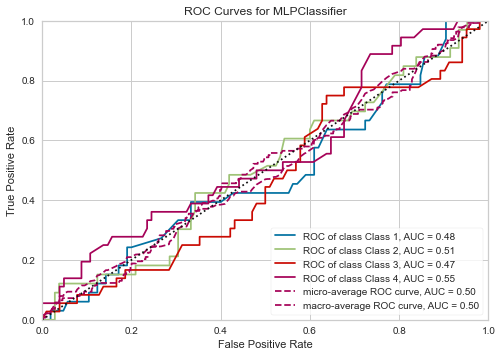

------------------

f1: 0.27500573008031187

AUC: 0.5241515395500903

Accuracy: 0.2898550724637681

CM: 
[[ 3  8  8 14]
 [ 4 11  8 10]
 [ 3  9 10 14]
 [ 6  8  6 16]] 

-------CURVA ROC-----------



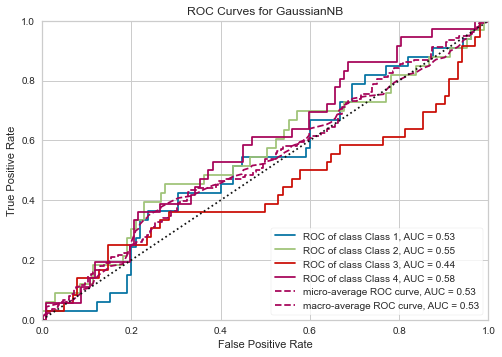

------------------

SVM 

C:0.1, k:rbf
, g:1

26.066003143006807

---------------------------
f1: 0.10794602698650674

AUC: 0.5

Accuracy: 0.2608695652173913

CM: 
[[ 0  0  0 33]
 [ 0  0  0 33]
 [ 0  0  0 36]
 [ 0  0  0 36]] 

-------CURVA ROC-----------



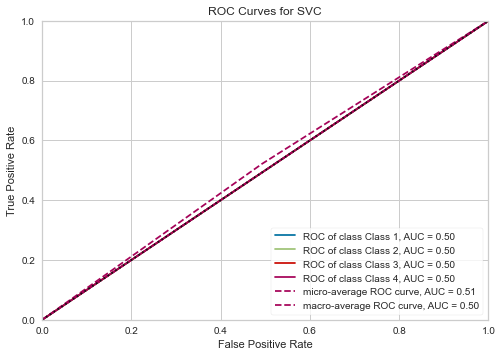

------------------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'euclidian' not valid. Use sorted(sklearn.ne

KNN 

k:11, w:distance, m:chebyshev

28.07869157790583

---------------------------
f1: 0.18845807482311147

AUC: 0.47265334401949916

Accuracy: 0.18840579710144928

CM: 
[[ 5  5 12 12]
 [ 7  5 14  7]
 [15  6  6  8]
 [ 7  9 10 10]] 

-------CURVA ROC-----------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.23895776 0.23895776 0.24938401 0.25020468
 0.25181111 0.2485905  0.26791029 0.2638884  0.28077722 0.26467804
 0.25744718 0.26548319 0.26227616 0.26630386 0.26226452 0.261471
 0.25503948 0.26549095 0.25262984 0.27112896 0.25745106 0.27112896
 0.2550259  0.26307161 0.25100596 0.26467998 0.25502784 0.25986264
 0.25180917 0.25664203 0.25905361 0.25824845 0.24940729 0.24940729
 0.27191665 0.2735483  0.27837534 0.27435151 0.26629998 0.26629998
 0.27354054 0.26792387 0.2695303  0.280

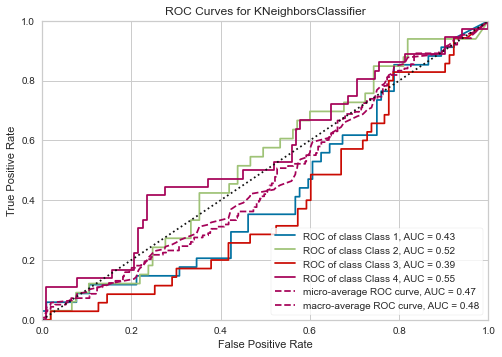

------------------

DT 

md:3, c:entropy

25.502396057660597

---------------------------
f1: 0.1518691051299747

AUC: 0.5028292633844637

Accuracy: 0.2246376811594203

CM: 
[[ 0  0  9 25]
 [ 0  1  8 24]
 [ 0  1  7 27]
 [ 0  0 13 23]] 

-------CURVA ROC-----------



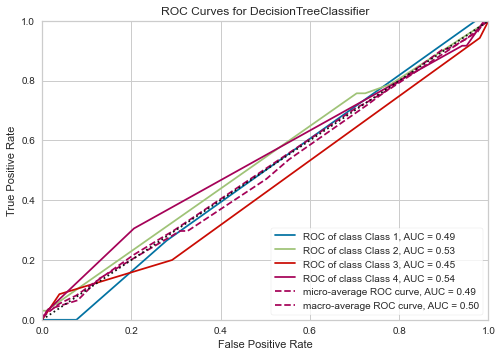

------------------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users

MLP 

hls:(50, 15, 5), a:tanh, s:adam, lr:adaptive, lri:0.0001

27.834623518227502

---------------------------
f1: 0.16305020735977074

AUC: 0.4863731600091361

Accuracy: 0.2246376811594203

CM: 
[[ 1  0  9 24]
 [ 4  0 16 13]
 [ 3  0 10 22]
 [ 2  1 13 20]] 

-------CURVA ROC-----------



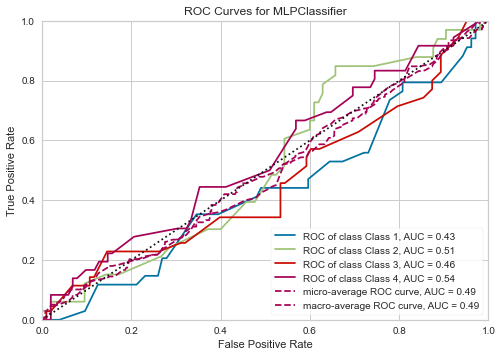

------------------

f1: 0.194672641648067

AUC: 0.4369756151618897

Accuracy: 0.21014492753623187

CM: 
[[ 1  8  9 16]
 [ 5  9  6 13]
 [10  7  5 13]
 [ 6  8  8 14]] 

-------CURVA ROC-----------



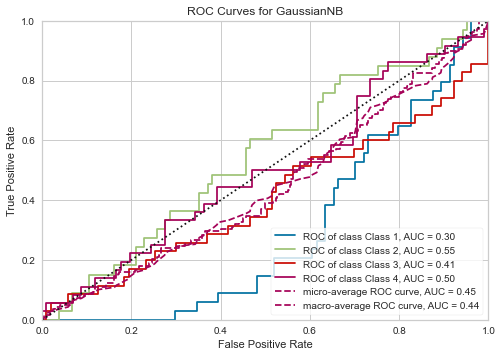

------------------

SVM 

C:0.1, k:rbf
, g:1

26.066003143006807

---------------------------
f1: 0.10794602698650674

AUC: 0.5

Accuracy: 0.2608695652173913

CM: 
[[ 0  0  0 34]
 [ 0  0  0 33]
 [ 0  0  0 35]
 [ 0  0  0 36]] 

-------CURVA ROC-----------



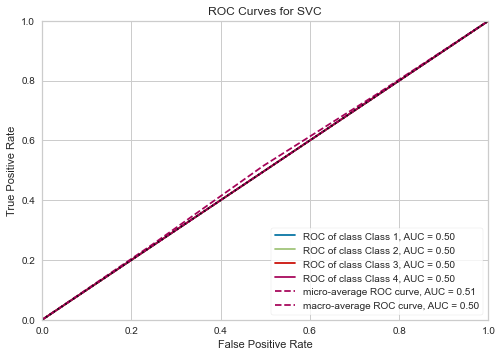

------------------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'euclidian' not valid. Use sorted(sklearn.ne

KNN 

k:17, w:uniform, m:chebyshev

27.676697126670934

---------------------------
f1: 0.2596125721262874

AUC: 0.5386283982191911

Accuracy: 0.2608695652173913

CM: 
[[ 6  8  8 12]
 [ 8  7  9  9]
 [14  3 11  7]
 [ 7  9  8 12]] 

-------CURVA ROC-----------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.24619832 0.24619832 0.25261044 0.25906137
 0.26066585 0.25423627 0.26468968 0.25986652 0.26228004 0.25906137
 0.26309877 0.27033739 0.26227034 0.25825621 0.25744912 0.25666143
 0.25824651 0.25906137 0.25503754 0.25665367 0.24537377 0.25744718
 0.24938789 0.25181499 0.24939759 0.25020662 0.25904585 0.25101178
 0.25986458 0.25180335 0.26307355 0.25180335 0.25503948 0.25503948
 0.25502784 0.25826009 0.26791805 0.26148071 0.25504918 0.25665949
 0.24942087 0.25504918 0.2647052  0.2

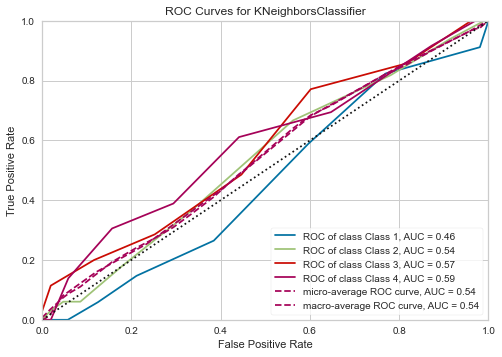

------------------

DT 

md:25, c:gini

26.227421764352094

---------------------------
f1: 0.21135283940250016

AUC: 0.47352292256384326

Accuracy: 0.21014492753623187

CM: 
[[10  9  7  8]
 [11  5  8  9]
 [ 6 14  6  9]
 [ 8 12  8  8]] 

-------CURVA ROC-----------



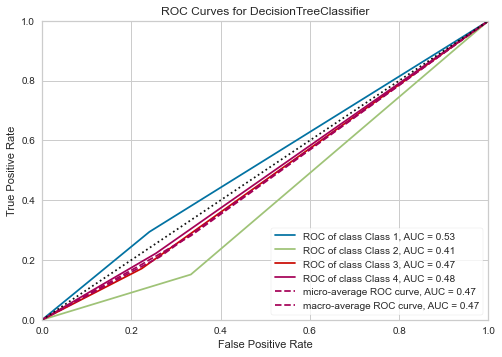

------------------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users

MLP 

hls:(100,), a:tanh, s:adam, lr:constant, lri:0.0001

27.112313990260557

---------------------------
f1: 0.3332133453081383

AUC: 0.5495482368031387

Accuracy: 0.35507246376811596

CM: 
[[10  2 10 12]
 [ 7  3 14  9]
 [ 3  3 19 10]
 [ 4  8  7 17]] 

-------CURVA ROC-----------



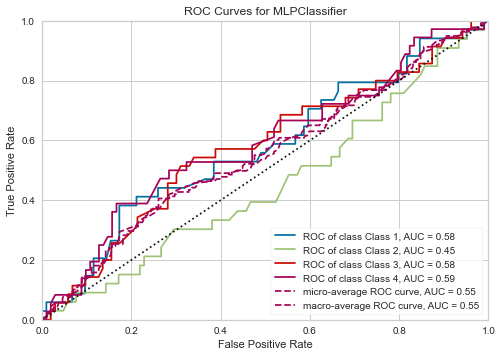

------------------

f1: 0.26652611285038574

AUC: 0.5021191443932279

Accuracy: 0.26811594202898553

CM: 
[[ 7  8  7 12]
 [ 4 12  7 10]
 [ 7  4  7 17]
 [ 4 11 10 11]] 

-------CURVA ROC-----------



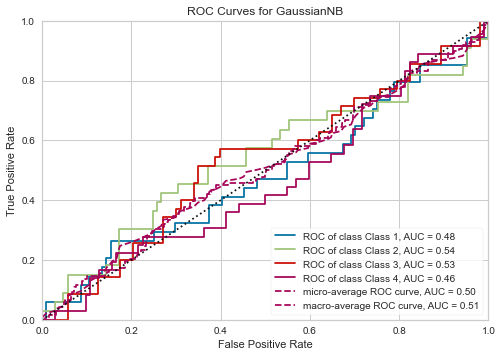

------------------

SVM 

C:0.1, k:rbf
, g:1

26.066003143006807

---------------------------
f1: 0.10794602698650674

AUC: 0.5

Accuracy: 0.2608695652173913

CM: 
[[ 0  0  0 34]
 [ 0  0  0 33]
 [ 0  0  0 35]
 [ 0  0  0 36]] 

-------CURVA ROC-----------



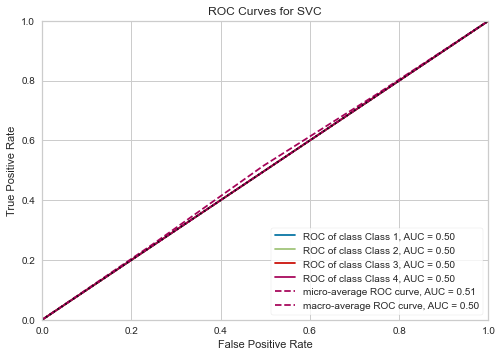

------------------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'euclidian' not valid. Use sorted(sklearn.ne

KNN 

k:17, w:uniform, m:chebyshev

28.641716624953922

---------------------------
f1: 0.26320827741553177

AUC: 0.5085561164152382

Accuracy: 0.26811594202898553

CM: 
[[ 7  9 13  5]
 [ 7  6 10 10]
 [ 6  7 14  8]
 [ 4  8 14 10]] 

-------CURVA ROC-----------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.24940535 0.24940535 0.25340201 0.25421687
 0.26466445 0.26547543 0.26870186 0.2751392  0.26709543 0.26387288
 0.26870186 0.26307355 0.26548125 0.26307937 0.27192635 0.27353084
 0.26952253 0.26066003 0.26710708 0.26228004 0.25342142 0.26146712
 0.26871932 0.2687135  0.26710708 0.26307743 0.27031023 0.26468386
 0.26789089 0.27030441 0.25905167 0.26789671 0.25422851 0.25422851
 0.2662864  0.2638884  0.26386706 0.25743554 0.26067361 0.26145936
 0.26308519 0.26389228 0.26709738 0.2

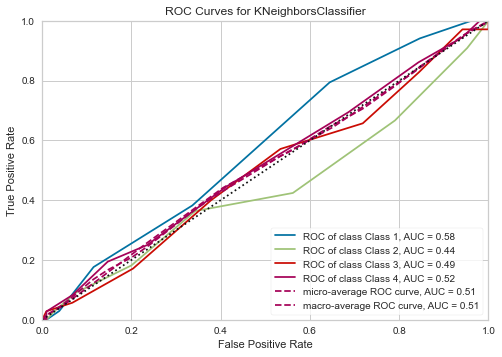

------------------

DT 

md:20, c:gini

26.951865432745475

---------------------------
f1: 0.2336520692151709

AUC: 0.48771364386773586

Accuracy: 0.2318840579710145

CM: 
[[ 8 10 10  6]
 [ 8  7 12  6]
 [14  5  7  9]
 [ 9  8  9 10]] 

-------CURVA ROC-----------



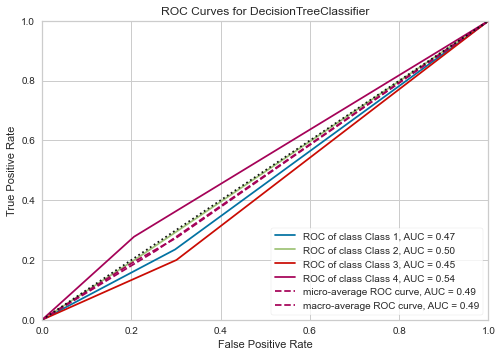

------------------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users

MLP 

hls:(100,), a:tanh, s:adam, lr:adaptive, lri:0.0001

27.192635275401116

---------------------------
f1: 0.25713112186230636

AUC: 0.5186766684422269

Accuracy: 0.2608695652173913

CM: 
[[ 6  5  6 17]
 [ 7  7  6 13]
 [ 4  8 10 13]
 [ 8  3 12 13]] 

-------CURVA ROC-----------



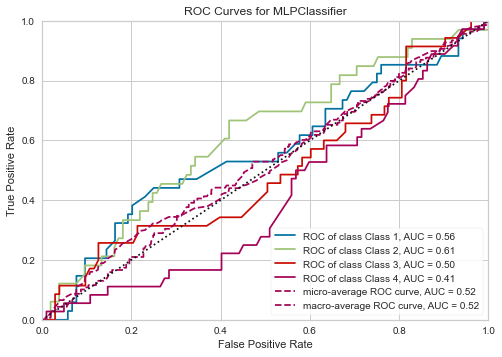

------------------

f1: 0.23193608966983756

AUC: 0.5091284910978007

Accuracy: 0.2608695652173913

CM: 
[[ 1 10 12 11]
 [ 5  5  7 16]
 [ 6  7 11 11]
 [ 1  9  7 19]] 

-------CURVA ROC-----------



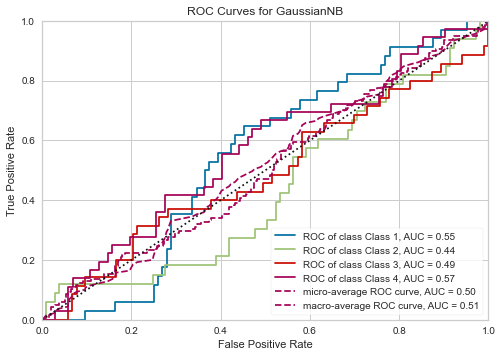

------------------

SVM 

C:0.1, k:rbf
, g:1

26.066003143006807

---------------------------
f1: 0.10794602698650674

AUC: 0.5

Accuracy: 0.2608695652173913

CM: 
[[ 0  0  0 34]
 [ 0  0  0 33]
 [ 0  0  0 35]
 [ 0  0  0 36]] 

-------CURVA ROC-----------



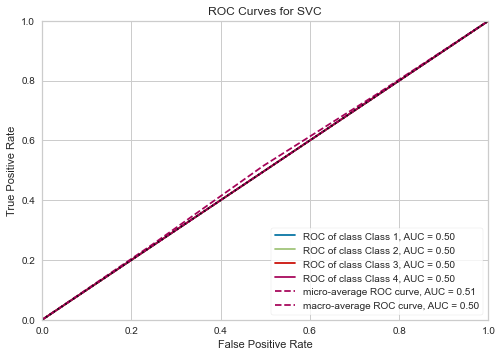

------------------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'euclidian' not valid. Use sorted(sklearn.ne

C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_classification.py", line 179, in fit
    return self._fit(X, y)
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 399, in _fit
    self._check_algorithm_metric()
  File "C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neighbors\_base.py", line 342, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'euclidian' not valid. Use sorted(sklearn.ne

KNN 

k:19, w:uniform, m:chebyshev

27.919019071454905

---------------------------
f1: 0.24260146982091255

AUC: 0.4980388773867035

Accuracy: 0.2463768115942029

CM: 
[[10 11  4  9]
 [ 9  5  9 10]
 [ 7  9  6 13]
 [ 7  8  8 13]] 

-------CURVA ROC-----------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.24860408 0.24860408 0.25583105 0.25020856
 0.25341171 0.24859438 0.2437654  0.24698601 0.25181693 0.2502008
 0.261471   0.25262208 0.25664203 0.25423821 0.26148265 0.25504724
 0.25745688 0.25262984 0.2526182  0.257453   0.26146712 0.2526376
 0.25583881 0.25423433 0.25904779 0.2461828  0.25823875 0.26468386
 0.25742778 0.25663427 0.25340589 0.25261238 0.24458219 0.24458219
 0.25100984 0.2510176  0.25020662 0.25985876 0.25584463 0.25502978
 0.25422851 0.24617892 0.25182469 0.253

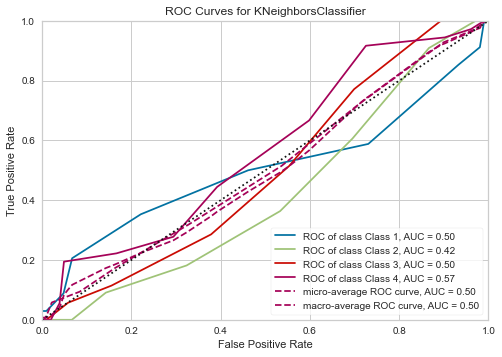

------------------

DT 

md:3, c:entropy

27.67630910113886

---------------------------
f1: 0.1904939310731813

AUC: 0.4759258695426641

Accuracy: 0.2971014492753623

CM: 
[[ 0 16  0 18]
 [ 0 11  0 22]
 [ 0  4  0 31]
 [ 0  5  1 30]] 

-------CURVA ROC-----------



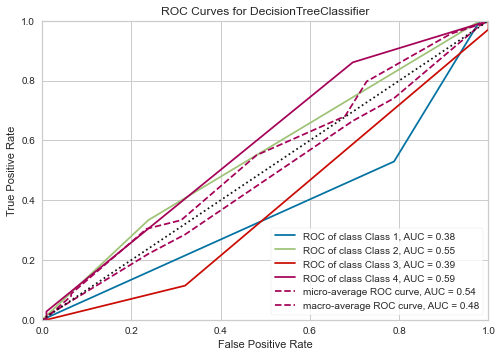

------------------



C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jwsl\anaconda3\envs\DataScience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users

MLP 

hls:(100, 25, 10), a:tanh, s:sgd, lr:adaptive, lri:0.05

27.593271637273737

---------------------------
f1: 0.28193664494876797

AUC: 0.5224001319163296

Accuracy: 0.2898550724637681

CM: 
[[ 7  6 13  8]
 [ 8  6  7 12]
 [ 5  3 12 15]
 [ 8  5  8 15]] 

-------CURVA ROC-----------



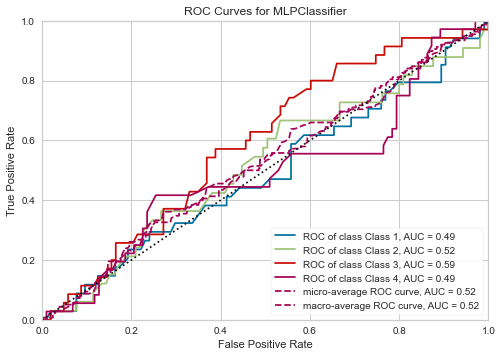

------------------

f1: 0.2847382457711229

AUC: 0.5227205784963671

Accuracy: 0.2971014492753623

CM: 
[[ 5 10  9 10]
 [ 1  8 12 12]
 [ 7  7 10 11]
 [ 6  7  5 18]] 

-------CURVA ROC-----------



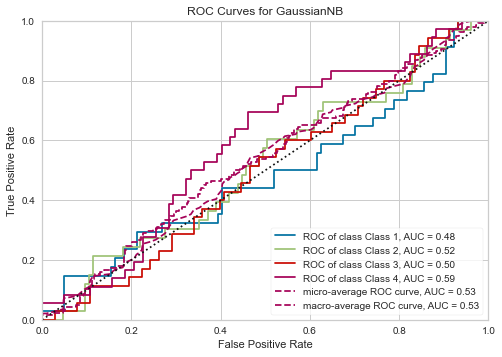

------------------

SVM 

C:0.1, k:rbf
, g:1

26.066003143006807

---------------------------
f1: 0.10794602698650674

AUC: 0.5

Accuracy: 0.2608695652173913

CM: 
[[ 0  0  0 34]
 [ 0  0  0 33]
 [ 0  0  0 35]
 [ 0  0  0 36]] 

-------CURVA ROC-----------



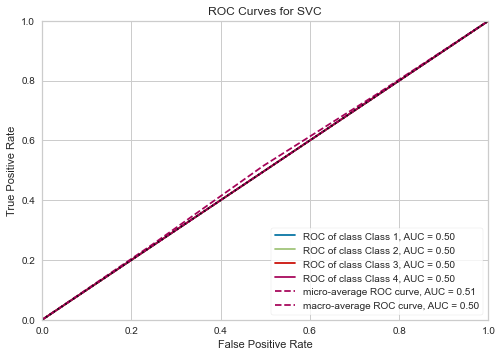

------------------

GNB
Acurácia média (desvio): 0.239000 +- (0.038406263)
F1-score média (desvio): 0.225660 +- (0.039192114)
AUC média (desvio): 0.481182 +- (0.030393888)

Matriz de Confusão:  
[[ 31  82  97 125]
 [ 40  83  89 119]
 [ 63  84  70 138]
 [ 44  89  81 146]]


---------------------------
KNN
Acurácia média (desvio): 0.257069 +- (0.043435224)
F1-score média (desvio): 0.255121 +- (0.043835213)
AUC média (desvio): 0.504385 +- (0.030905041)

Matriz de Confusão:  
[[ 83  75  93  84]
 [ 87  67  89  88]
 [ 97  72 102  84]
 [ 83  76  98 103]]


---------------------------
DT
Acurácia média (desvio): 0.238927 +- (0.035551876)
F1-score média (desvio): 0.213201 +- (0.033816278)
AUC média (desvio): 0.486180 +- (0.018959257)

Matriz de Confusão:  
[[ 55  83  76 121]
 [ 64  67  84 116]
 [ 61  66  66 162]
 [ 64  69  85 142]]


---------------------------
MLP
Acurácia média (desvio): 0.257080 +- (0.038355122)
F1-score média (desvio): 0.233104 +- (0.048631382)
AUC média (desvio): 0.499707 

In [45]:
#%%time
evaluate_model_with_kfold(StratifiedKFold(n_splits=10, shuffle=True, random_state=199))